In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px

import PV_ICE

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'MESC-NRELStdScens')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines'/'NRELStdScenarios')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
#altBaselinesfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'Energy_CellModuleTechCompare')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pyplot ", plt.matplotlib.__version__)
print("PV_ICE version ", PV_ICE.__version__)

Python version  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.0.3
pyplot  3.7.2
PV_ICE version  


### Bring in NREL Standard Scenarios data for projection
https://scenarioviewer.nrel.gov/ download the data, save it to the NRELStdScenarios folder in baselines. 

ReEDS capacity data is cumulative, and only reports even years, so we need to data munge.

In [3]:
stdsceninput_raw = pd.read_csv(os.path.join(inputfolder, 'StdScen23_Mid_Case_100by2035_annual_national.csv'),
           skiprows=[0,1,2,4], header=[0], index_col=1)
#other scenario options:
#StdScen23_Mid_Case_NoNascent_annual_national.csv
#StdScen23_Mid_Case_100by2035_annual_national.csv
#StdScen23_Mid_Case_annual_national.csv

In [39]:
stdscen_pv_evens = stdsceninput_raw.filter(like='(MW)').filter(like='PV')
stdscen_pv_evens.head(2)

Behind-the-meter PV capacity (MW)  Utility-scale PV capacity (MW)
Year                                                                   
2024                            40722.7                        148218.7
2026                            53793.8                        205332.9

In [38]:
#take the difference betwen even years to get annual additions from cumulative
stdscens_evens_added_cap = stdscen_pv_evens.diff()
#divide by 2 to evenly distribute across odd and even years
stdscens_added_cap = stdscens_evens_added_cap/2

Behind-the-meter PV capacity (MW)  Utility-scale PV capacity (MW)
Year                                                                   
2024                                NaN                             NaN
2026                            6535.55                         28557.1

In [6]:
#now make previous odds = next year evens deployment
idx_temp = pd.RangeIndex(start=2024,stop=2051,step=1) #create the index
stdscens_added_cap_filled = stdscens_added_cap.reindex(idx_temp, method='bfill')
#stdscens_added_cap_filled

In [7]:
#Reeds is in MWac, we're in MWdc, so multiply residential by 1.1 and utility by 1.3
stdscens_pv_filled_dc = pd.DataFrame()
stdscens_pv_filled_dc['Behind-the-meter PV capacity (MWdc)'] = stdscens_added_cap_filled['Behind-the-meter PV capacity (MW)']*1.1
stdscens_pv_filled_dc['Utility-scale PV capacity (MWdc)'] = stdscens_added_cap_filled['Utility-scale PV capacity (MW)']*1.3
stdscens_pv_filled_dc

Behind-the-meter PV capacity (MWdc)  Utility-scale PV capacity (MWdc)
2024                                  NaN                               NaN
2025                             7189.105                         37124.230
2026                             7189.105                         37124.230
2027                             9771.410                         22825.400
2028                             9771.410                         22825.400
2029                            13623.830                         13095.160
2030                            13623.830                         13095.160
2031                            10514.350                         63593.075
2032                            10514.350                         63593.075
2033                             7063.650                         95122.755
2034                             7063.650                         95122.755
2035                             2952.455                         56908.800
2036                             2952.455                         56908.800
2037                             2737.845                         17976.270
2038                             2737.845                         17976.270
2039                             2648.360                          5052.840
2040                             2648.360                          5052.840
2041                             2726.240                          3272.945
2042                             2726.240                          3272.945
2043                             3087.755                         15284.165
2044                             3087.755                         15284.165
2045                             3060.145                         28362.750
2046                             3060.145                         28362.750
2047                             3500.805                         27380.795
2048                             3500.805                         27380.795
2049                             3923.590                         19120.855
2050                             3923.590                         19120.855

Text(0, 0.5, 'Annual Installed Capacity\n[MWdc]')

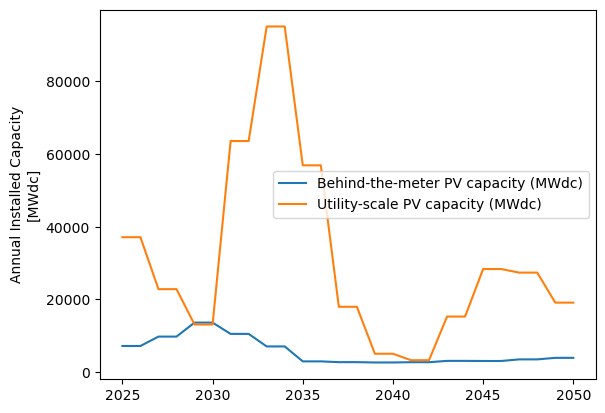

In [8]:
plt.plot(stdscens_pv_filled_dc)
plt.legend(stdscens_pv_filled_dc.columns)
plt.ylabel('Annual Installed Capacity\n[MWdc]')

### Set up PV ICE simulation using historical US installs with the NREL Std Scenarios projection


In [9]:
#c-Si
MATERIALS = ['glass','aluminium_frames','silver','silicon', 'copper', 'encapsulant', 'backsheet']
moduleFile = os.path.join(baselinesfolder, 'baseline_modules_mass_US_updatedT50T90.csv')
#CdTe
MATERIALS_CdTe = ['glass_cdte','aluminium_frames_cdte', 'copper_cdte', 'encapsulant_cdte','cadmium','tellurium']
moduleFile_CdTe = os.path.join(baselinesfolder, 'baseline_modules_mass_US_CdTe.csv')

In [10]:
sim1 = PV_ICE.Simulation(name='MESC_StdScen', path=testfolder)
scens = ['23_MidCase_cSi', '23_MidCase_CdTe']

#c-Si
sim1.createScenario(name='23_MidCase_cSi', massmodulefile=moduleFile) #create the scenario, name and mod file attach
for mat in MATERIALS:
    materialfile = os.path.join(baselinesfolder, 'baseline_material_mass_'+str(mat)+'.csv')
    sim1.scenario['23_MidCase_cSi'].addMaterial(mat, massmatfile=materialfile) # add all materials listed in MATERIALS
#CdTe
sim1.createScenario(name='23_MidCase_CdTe', massmodulefile=moduleFile_CdTe) #create the scenario, name and mod file attach
for mat in MATERIALS_CdTe:
    materialfile = os.path.join(baselinesfolder, 'baseline_material_mass_'+str(mat)+'.csv')
    sim1.scenario['23_MidCase_CdTe'].addMaterial(mat, massmatfile=materialfile) # add all materials listed in MATERIALS_cdte

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\MESC-NRELStdScens
Baseline folder directed to default:  C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\baselines
No energy module file passed. If desired, pass one of the following options:  ['baseline_modules_energy.csv', 'baseline_modules_energy_CdTe.csv']
No energy module file passed. If desired, pass one of the following options:  ['baseline_modules_energy.csv', 'baseline_modules_energy_CdTe.csv']


For future deployment in the US of c-Si and CdTe, the assumptions are:
- all Residential will be c-Si
- CdTe will max out at 22 GW in 2030, and c-Si will make up the remaining demand to fullfill Utility deployment

We will linearly interpolate between historical CdTe Deployment and the 22 GW in 2030.

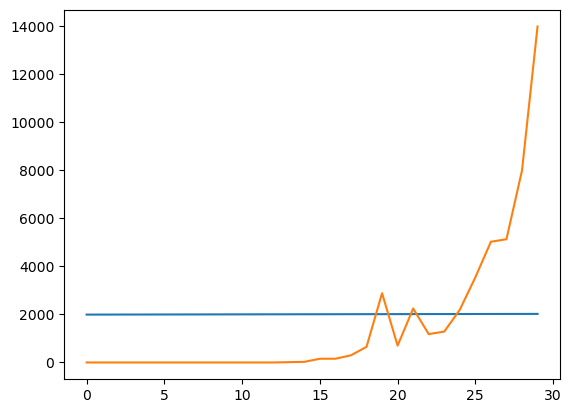

In [11]:
plt.plot(sim1.scenario['23_MidCase_CdTe'].dataIn_m.loc[:(2024-1995),['year','new_Installed_Capacity_[MW]']])

In [12]:
#linearly interpolate CdTe
#estimated 2024 install = 14GW
idx_temp = pd.RangeIndex(start=2024,stop=2051,step=1) #create the index
CdTeRamp = pd.DataFrame(index=idx_temp, columns=['CdTe_deploy_[MWdc]'], dtype=float)
CdTeRamp.loc[2024] = 14000
CdTeRamp.loc[2030] = 22000
CdTeRamp_full = round(CdTeRamp.interpolate(),0)
#CdTeRamp_full

In [13]:
#Modify the CdTe Scenario deployment schedule
sim1.modifyScenario(scenarios='23_MidCase_CdTe',stage='new_Installed_Capacity_[MW]', 
                    value=CdTeRamp_full.sum(axis=1), start_year=2024) #

Text(0, 0.5, 'Annual Installed Capacity\n[MWdc]')

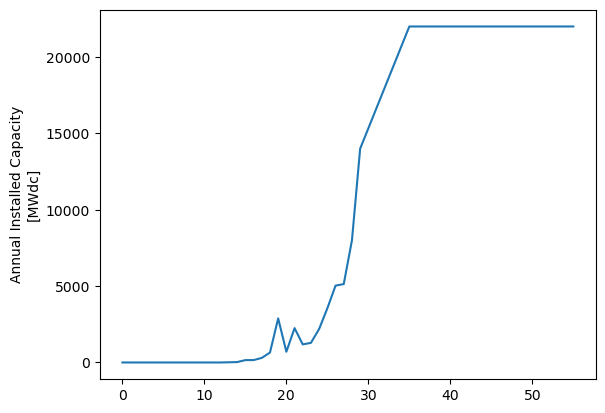

In [14]:
plt.plot(sim1.scenario['23_MidCase_CdTe'].dataIn_m.loc[:,'new_Installed_Capacity_[MW]'])
plt.ylabel('Annual Installed Capacity\n[MWdc]')

In [15]:
#now create the silicon deployment by subtracting CdTe from the total Utility deployment, add resi
mescdeploybytech = pd.DataFrame()
utilitydeploytotal = stdscens_pv_filled_dc['Utility-scale PV capacity (MWdc)'].values
CdTedeployutility = sim1.scenario['23_MidCase_CdTe'].dataIn_m.loc[(2024-1995):,'new_Installed_Capacity_[MW]'].values
resi = stdscens_pv_filled_dc['Behind-the-meter PV capacity (MWdc)'].values
mescdeploybytech['cSi_[MWdc]'] = utilitydeploytotal-CdTedeployutility+resi
mescdeploybytech.iloc[0,0]=14000 #fix nan issue
mescdeploybytech['CdTe_[MWdc]'] = sim1.scenario['23_MidCase_CdTe'].dataIn_m.loc[(2024-1995):,'new_Installed_Capacity_[MW]'].values
mescdeploybytech.index = idx_temp

Text(0, 0.5, 'Annual Installed Capacity\n[MWdc]')

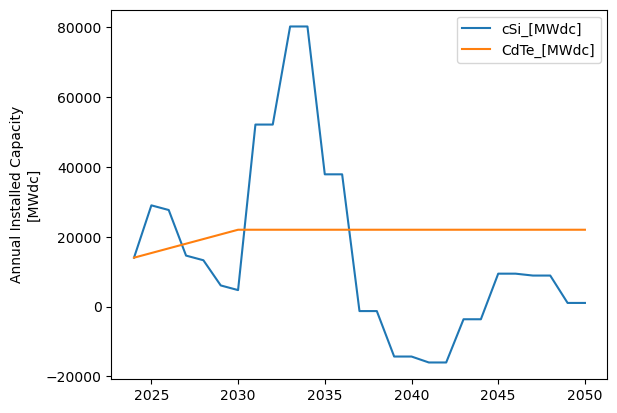

In [16]:
plt.plot(mescdeploybytech)
plt.legend(mescdeploybytech.columns)
plt.ylabel('Annual Installed Capacity\n[MWdc]')

In [17]:
#Modify the c-Si deployment schedule
sim1.modifyScenario(scenarios=['23_MidCase_cSi'],stage='new_Installed_Capacity_[MW]', 
                    value=mescdeploybytech['cSi_[MWdc]'], start_year=2024) #

Text(0, 0.5, 'Annual Installed Capacity\n[MWdc]')

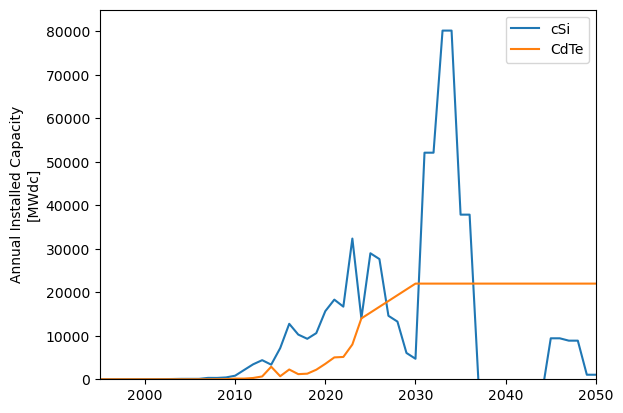

In [18]:
yeargraph = sim1.scenario['23_MidCase_cSi'].dataIn_m.loc[:,'year']
plt.plot(yeargraph,sim1.scenario['23_MidCase_cSi'].dataIn_m.loc[:,'new_Installed_Capacity_[MW]'], label='cSi')
plt.plot(yeargraph,sim1.scenario['23_MidCase_CdTe'].dataIn_m.loc[:,'new_Installed_Capacity_[MW]'], label='CdTe')
plt.legend()
plt.ylim(0,)
plt.xlim(1995,2050)
plt.ylabel('Annual Installed Capacity\n[MWdc]')

### Create High recycling scenario
Assume high recycling = Solar Cycle ideal (Dias 2022, Renewable and Sustainable Energy Reviews)
- modules, 75% sent to recycling
- glass, 100% closed loop
- aluminium frames, 100% closed loop
- silver, 100% closed loop
- copper, 100% closed loop
- silicon, 100% LQ recycling

We don't need to create a high CdTe recycling scenario, already set to 100% collect and recycle.

In [19]:
sim1.createScenario(name='23_MidCase_cSi_hiR', massmodulefile=moduleFile)
for mat in MATERIALS:
    materialfile = os.path.join(baselinesfolder, 'baseline_material_mass_'+str(mat)+'.csv')
    sim1.scenario['23_MidCase_cSi_hiR'].addMaterial(mat, massmatfile=materialfile) # add all materials listed in MATERIALS

#modify deployment curve as before
sim1.modifyScenario(scenarios=['23_MidCase_cSi_hiR'],stage='new_Installed_Capacity_[MW]', 
                    value=mescdeploybytech['cSi_[MWdc]'], start_year=2024) #
#modify EoL recycling variables
#module
sim1.modifyScenario(scenarios=['23_MidCase_cSi_hiR'],stage='mod_EOL_collection_eff', value=75, start_year=2024) #collect 75%
sim1.modifyScenario(scenarios=['23_MidCase_cSi_hiR'],stage='mod_EOL_pg4_recycled', value=100, start_year=2024) #recycle all collected
sim1.modifyScenario(scenarios=['23_MidCase_cSi_hiR'],stage='mod_EOL_pb4_recycled', value=100, start_year=2024) #

#material, all become a recycling target, and send to high quality
sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100, start_year=2024)
sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 100, start_year=2024)

sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100, start_year=2024)
sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100, start_year=2024)

sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('silver', 'mat_PG4_Recycling_target', 100, start_year=2024)
sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('silver', 'mat_EOL_Recycled_into_HQ', 100, start_year=2024)

sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('copper', 'mat_PG4_Recycling_target', 100, start_year=2024)
sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('copper', 'mat_EOL_Recycled_into_HQ', 100, start_year=2024)

sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100, start_year=2024)
sim1.scenario['23_MidCase_cSi_hiR'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100, start_year=2024)


No energy module file passed. If desired, pass one of the following options:  ['baseline_modules_energy.csv', 'baseline_modules_energy_CdTe.csv']


In [20]:
#create 0 recycling scenario to calculate end of life mass demand in 2030.
sim1.createScenario(name='23_MidCase_cSi_0R', massmodulefile=moduleFile)
for mat in MATERIALS:
    materialfile = os.path.join(baselinesfolder, 'baseline_material_mass_'+str(mat)+'.csv')
    sim1.scenario['23_MidCase_cSi_0R'].addMaterial(mat, massmatfile=materialfile) # add all materials listed in MATERIALS

#modify deployment curve as before
sim1.modifyScenario(scenarios=['23_MidCase_cSi_0R'],stage='new_Installed_Capacity_[MW]', 
                    value=mescdeploybytech['cSi_[MWdc]'], start_year=2024) #

#set recycling to 0, only consider EoL
sim1.scenMod_noCircularity(scenarios='23_MidCase_cSi_0R')
sim1.scenMod_PerfectManufacturing(scenarios='23_MidCase_cSi_0R')

No energy module file passed. If desired, pass one of the following options:  ['baseline_modules_energy.csv', 'baseline_modules_energy_CdTe.csv']


In [21]:
#sim1.scenario['23_MidCase_CdTe'].dataIn_m['mod_EOL_collection_eff']
#sim1.scenario['23_MidCase_cSi'].dataIn_m['mod_EOL_collection_eff']
#sim1.scenario['23_MidCase_cSi_hiR'].material['glass'].matdataIn_m.keys()

# Run the scenarios

In [22]:
sim1.calculateMassFlow()

>>>> Calculating Material Flows <<<<

Working on Scenario:  23_MidCase_cSi
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  23_MidCase_cSi  =  1348383.8187235205  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  23_MidCase_cSi  =  844.1772852074654  tonnes.
==> Working on Material :  aluminium_frames
ReMFG surplus End of Sim for Mat  aluminium_frames  Scenario  23_MidCase_cSi  =  152287.8877488187  tonnes.
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  23_MidCase_cSi  =  11897.913469212981  tonnes.
==> Working on Material :  silver
ReMFG surplus End of Sim for Mat  silver  Scenario  23_MidCase_cSi  =  210.16455003624927  tonnes.
Recycled surplus End of Sim for Mat  silver  Scenario  23_MidCase_cSi  =  0.7649311430183995  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  23_MidCase_cSi  =  44353.05609007007  tonn

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:1427: RuntimeWarning: invalid value encountered in scalar subtract
  recycledsurplus = ( dm['mat_MFG_Recycled_HQ_into_MFG'].loc[rr] + #mfg scrap in that year


Working on Scenario:  23_MidCase_cSi_hiR
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  23_MidCase_cSi_hiR  =  1348383.8187235205  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  23_MidCase_cSi_hiR  =  56883.33841556675  tonnes.
==> Working on Material :  aluminium_frames
ReMFG surplus End of Sim for Mat  aluminium_frames  Scenario  23_MidCase_cSi_hiR  =  152287.8877488187  tonnes.
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  23_MidCase_cSi_hiR  =  126090.65346605086  tonnes.
==> Working on Material :  silver
ReMFG surplus End of Sim for Mat  silver  Scenario  23_MidCase_cSi_hiR  =  210.16455003624927  tonnes.
Recycled surplus End of Sim for Mat  silver  Scenario  23_MidCase_cSi_hiR  =  154.99196436462034  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  23_MidCase_cSi_hiR  =  44353.05609007007  tonnes.
Re

In [23]:
ii_yearly, ii_cumu = sim1.aggregateResults()

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  USyearly[nicekey+'_'+mat+'_'+self.name+'_'+scen] = self.scenario[scen].material[mat].matdataOut_m[keywd]
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  USyearly[nicekey+'_'+mat+'_'+self.name+'_'+scen] = self.scenario[scen].material[mat].matdataOut_m[keywd]
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2167: PerformanceWarning: DataFrame is highly fra

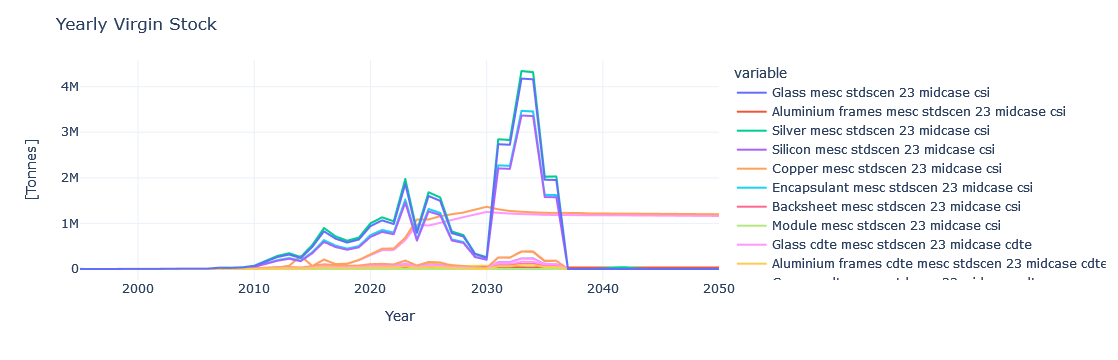

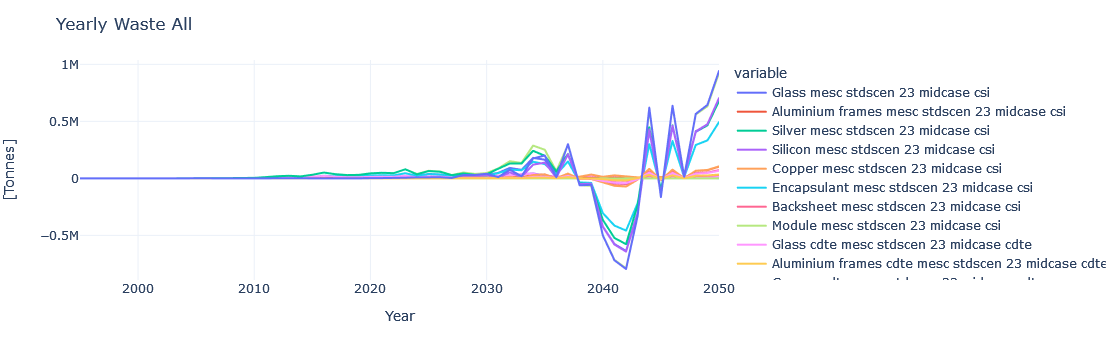

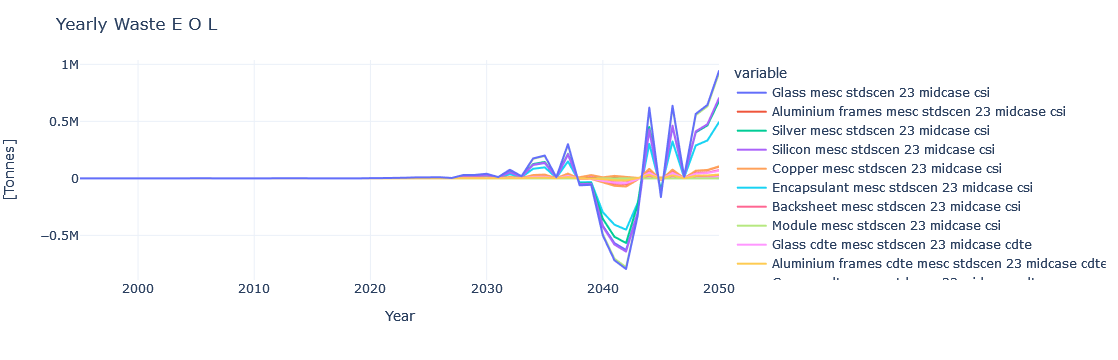

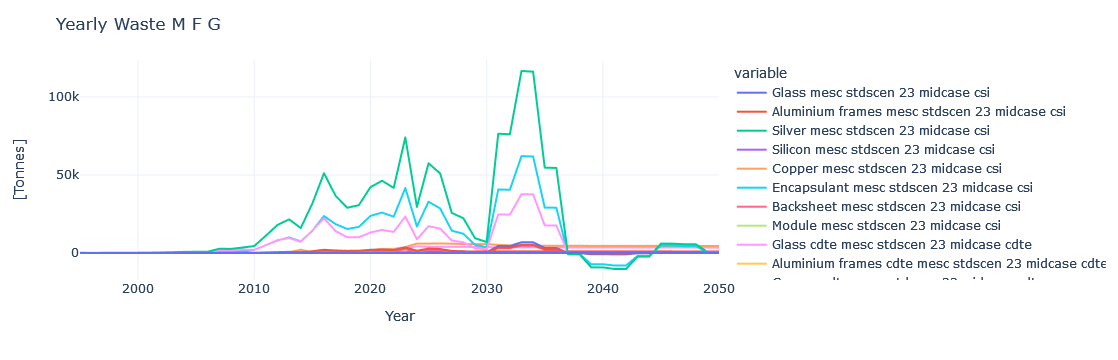

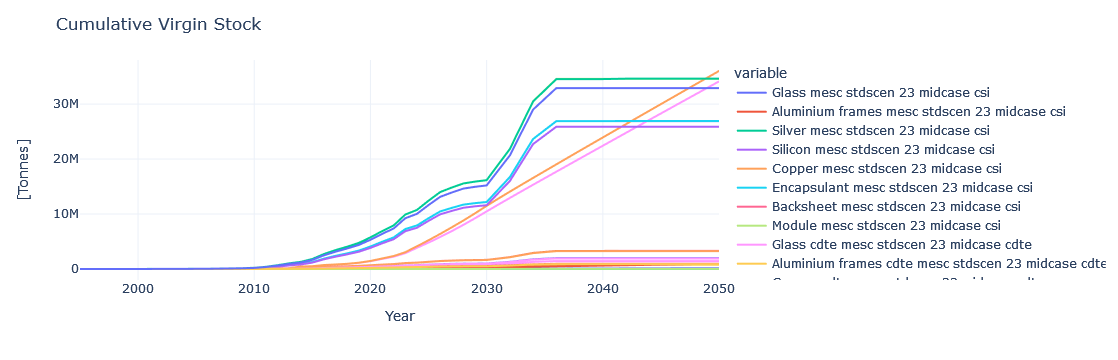

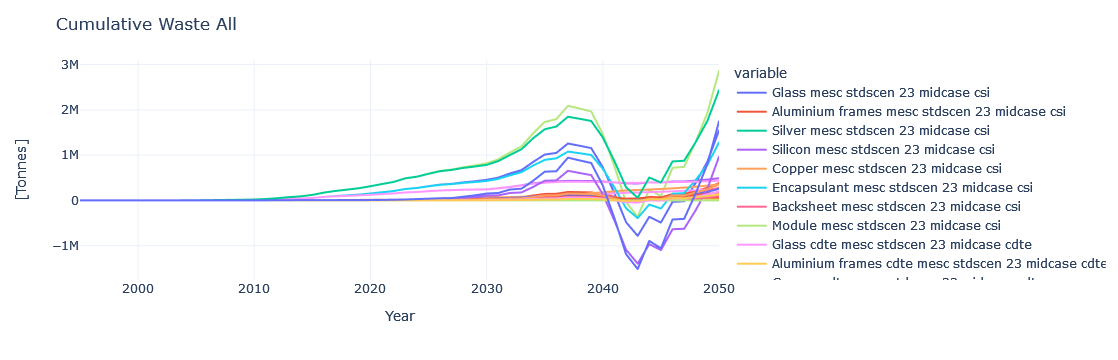

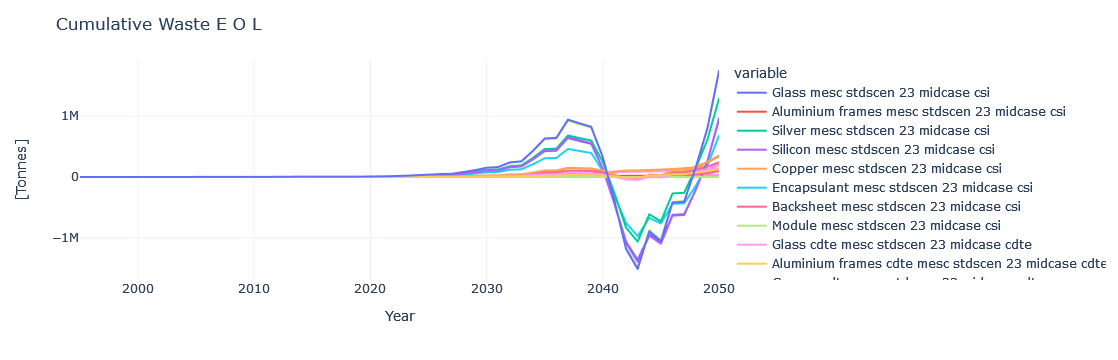

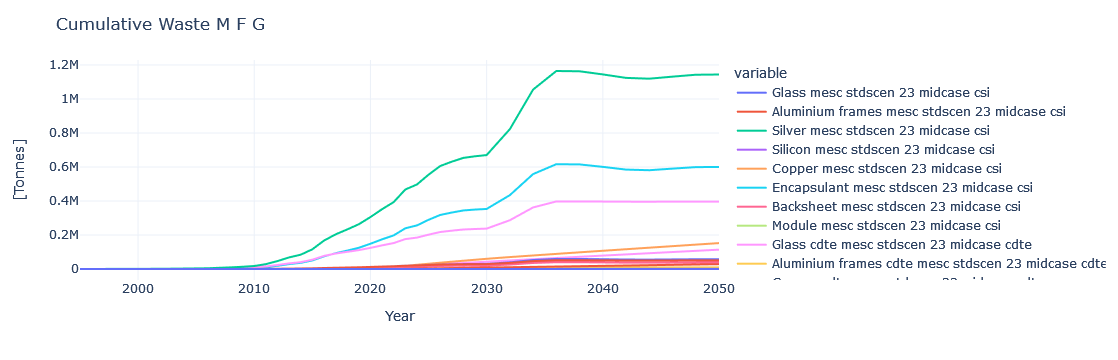

["MESC', 'StdScen', '23', 'MidCase', 'cSi", "MESC', 'StdScen', '23', 'MidCase', 'CdTe", "MESC', 'StdScen', '23', 'MidCase', 'cSi', 'hiR", "MESC', 'StdScen', '23', 'MidCase', 'cSi', '0R"]


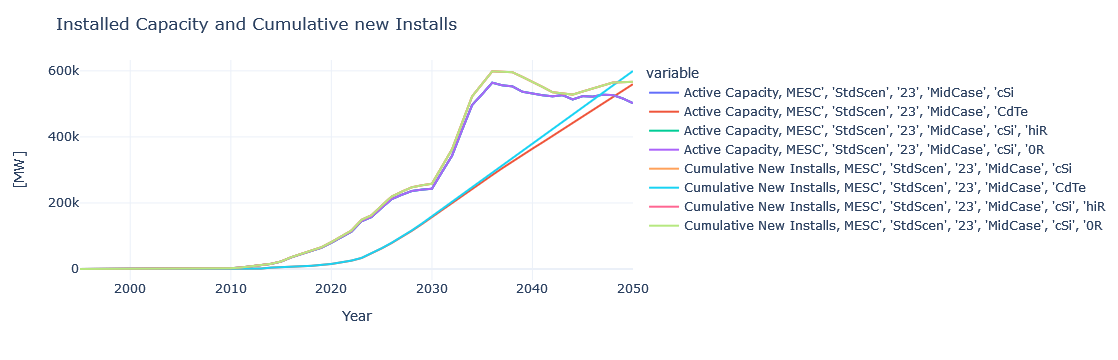

In [24]:
sim1.plotMetricResults()

In [25]:
recycled_by_mat = pd.DataFrame()
for mats in MATERIALS:
    recycled_by_mat[str(mats)] = sim1.scenario['23_MidCase_cSi'].material[mats].matdataOut_m['mat_EOL_Recycled_2_HQ']
for mats in MATERIALS:
    recycled_by_mat[str(mats+'_hiR')] = sim1.scenario['23_MidCase_cSi_hiR'].material[mats].matdataOut_m['mat_EOL_Recycled_2_HQ']
for mats_cdte in MATERIALS_CdTe:
    recycled_by_mat[str(mats_cdte)] = sim1.scenario['23_MidCase_CdTe'].material[mats_cdte].matdataOut_m['mat_EOL_Recycled_2_HQ']
recycled_by_mat.index = pd.RangeIndex(start=1995,stop=2051,step=1)
recycled_by_mat_tonnes = recycled_by_mat/1000000  # This is the ratio for grams to Metric tonnes
#SUM and Annual 2024-2030, 

In [26]:
recycled_by_mat_tonnes.loc[2024:2030,]

glass  aluminium_frames  silver  silicon  copper  encapsulant  \
2024  19.170014         41.500447     0.0      0.0     0.0          0.0   
2025  20.347898         41.391789     0.0      0.0     0.0          0.0   
2026  22.019460         44.069153     0.0      0.0     0.0          0.0   
2027   7.799168         14.955748     0.0      0.0     0.0          0.0   
2028  65.970255        130.824521     0.0      0.0     0.0          0.0   
2029  67.169584        131.356918     0.0      0.0     0.0          0.0   
2030  90.021086        174.120358     0.0      0.0     0.0          0.0   

      backsheet    glass_hiR  aluminium_frames_hiR  silver_hiR  silicon_hiR  \
2024        0.0  1775.001253            518.755591   18.456992   297.762340   
2025        0.0  1884.064635            517.397360   17.851945   262.735362   
2026        0.0  2038.838870            550.864410   17.390710   232.389187   
2027        0.0   722.145220            186.946851    3.192390    75.928343   
2028        0.0  6108.356991           1635.306514   50.463798   669.531092   
2029        0.0  6219.405893           1641.961472   45.872569   650.814490   
2030        0.0  8335.285768           2176.504475   56.420174   872.170952   

      copper_hiR  encapsulant_hiR  backsheet_hiR  glass_cdte  \
2024    2.830843              0.0            0.0   66.045262   
2025    3.003694              0.0            0.0  101.931271   
2026    3.248966              0.0            0.0  153.969708   
2027    1.145072              0.0            0.0  227.898120   
2028    9.738106              0.0            0.0  330.863692   
2029    9.910815              0.0            0.0  471.541081   
2030   13.281751              0.0            0.0  660.172328   

      aluminium_frames_cdte  copper_cdte  encapsulant_cdte   cadmium  \
2024               0.004125     1.643801               0.0  0.186428   
2025               0.013053     2.537586               0.0  0.283476   
2026               0.035230     3.834151               0.0  0.422172   
2027               0.084672     5.676870               0.0  0.616539   
2028               0.186636     8.244510               0.0  0.883813   
2029               0.385350    11.754295               0.0  1.244634   
2030               0.756794    16.463090               0.0  1.723065   

      tellurium  
2024   0.200481  
2025   0.304844  
2026   0.453994  
2027   0.663012  
2028   0.950432  
2029   1.338451  
2030   1.852947

In [27]:
recycled_by_mat_tonnes.loc[2024:2030,'glass':'backsheet']

glass  aluminium_frames  silver  silicon  copper  encapsulant  \
2024  19.170014         41.500447     0.0      0.0     0.0          0.0   
2025  20.347898         41.391789     0.0      0.0     0.0          0.0   
2026  22.019460         44.069153     0.0      0.0     0.0          0.0   
2027   7.799168         14.955748     0.0      0.0     0.0          0.0   
2028  65.970255        130.824521     0.0      0.0     0.0          0.0   
2029  67.169584        131.356918     0.0      0.0     0.0          0.0   
2030  90.021086        174.120358     0.0      0.0     0.0          0.0   

      backsheet  
2024        0.0  
2025        0.0  
2026        0.0  
2027        0.0  
2028        0.0  
2029        0.0  
2030        0.0

In [28]:
#set plot parameters
plt.rcParams.update({'font.size': 16})

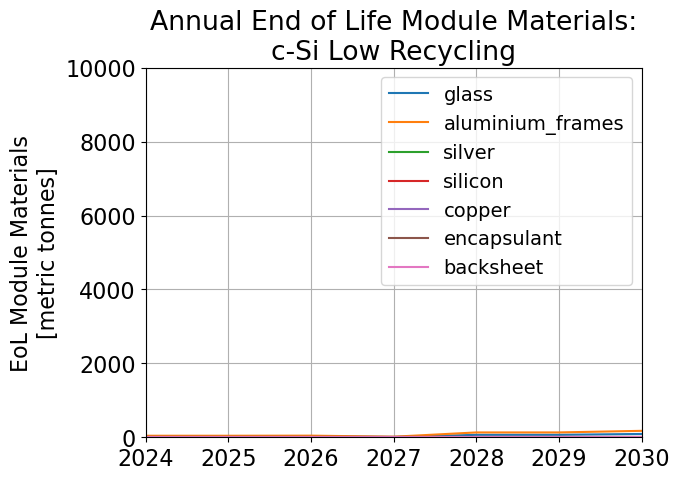

In [29]:
plt.plot(recycled_by_mat_tonnes.loc[2024:2030,'glass':'backsheet'])
plt.ylim(0,10000)
plt.xlim(2024,2030)
plt.title('Annual End of Life Module Materials:\nc-Si Low Recycling')
plt.ylabel('EoL Module Materials\n[metric tonnes]')
plt.legend(recycled_by_mat_tonnes.columns, fontsize=14)
plt.grid()

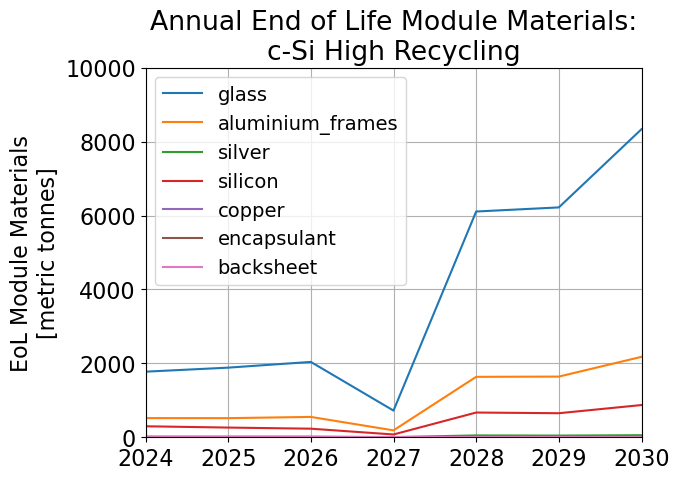

In [30]:
plt.plot(recycled_by_mat_tonnes.loc[2024:2030,].filter(like='_hiR'))
plt.ylim(0,10000)
plt.xlim(2024,2030)
plt.title('Annual End of Life Module Materials:\nc-Si High Recycling')
plt.ylabel('EoL Module Materials\n[metric tonnes]')
plt.legend(recycled_by_mat_tonnes.columns, fontsize=14)
plt.grid()

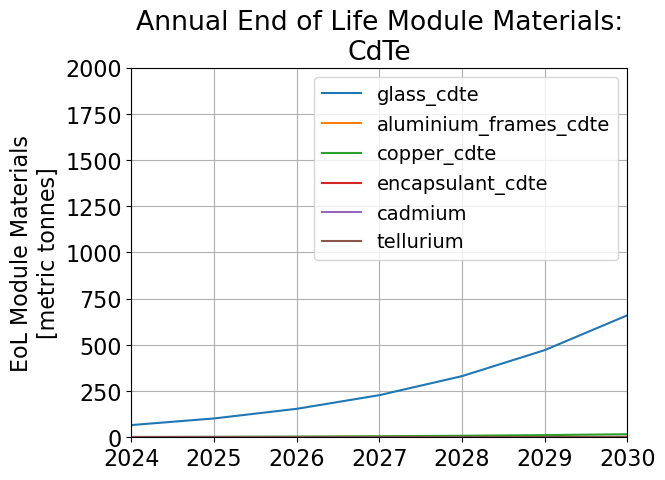

In [31]:
plt.plot(recycled_by_mat_tonnes.loc[2024:2030,'glass_cdte':])
plt.ylim(0,2000)
plt.xlim(2024,2030)
plt.title('Annual End of Life Module Materials:\nCdTe')
plt.ylabel('EoL Module Materials\n[metric tonnes]')
plt.legend(recycled_by_mat_tonnes.loc[2024:2030,'glass_cdte':].columns, fontsize=14)
plt.grid()

In [32]:
recycled_by_mat_tonnes.loc[2024:2030,].sum(axis=0)

glass                      292.497465
aluminium_frames           578.218934
silver                       0.000000
silicon                      0.000000
copper                       0.000000
encapsulant                  0.000000
backsheet                    0.000000
glass_hiR                27083.098630
aluminium_frames_hiR      7227.736673
silver_hiR                 209.648577
silicon_hiR               3061.331765
copper_hiR                  43.159248
encapsulant_hiR              0.000000
backsheet_hiR                0.000000
glass_cdte                2012.421462
aluminium_frames_cdte        1.465860
copper_cdte                 50.154305
encapsulant_cdte             0.000000
cadmium                      5.360127
tellurium                    5.764160
dtype: float64

## Annual Future Demand through 2030
i.e. how much module mass is leaving the field each year 2024-2030, is the "total demand"

In [33]:
sim1.scenario['23_MidCase_cSi'].dataOut_m.keys()

Index(['Area', 'Cumulative_Active_Area', 'EOL_BadStatus', 'EOL_Landfill0',
       'EOL_PATHS', 'EOL_PG', 'Effective_Capacity_[W]', 'Landfill_0_ProjLife',
       'MerchantTail_Area', 'MerchantTail_[W]', 'ModuleTotal_MFG', 'P2_stored',
       'P3_reMFG', 'P4_recycled', 'PB1_landfill', 'PB2_stored', 'PB3_reMFG',
       'PB3_reMFG_unyield', 'PB3_reMFG_yield', 'PB4_recycled', 'PG1_landfill',
       'PG2_stored', 'PG3_reMFG', 'PG3_reMFG_unyield', 'PG3_reMFG_yield',
       'PG4_recycled', 'Power_Degraded_[W]', 'Repaired_Area', 'Repaired_[W]',
       'Resold_Area', 'Resold_[W]', 'WeibullParams',
       'Yearly_Sum_Area_EOLby_Degradation', 'Yearly_Sum_Area_EOLby_Failure',
       'Yearly_Sum_Area_EOLby_ProjectLifetime', 'Yearly_Sum_Area_PathsBad',
       'Yearly_Sum_Area_PathsGood', 'Yearly_Sum_Area_atEOL',
       'Yearly_Sum_Power_EOLby_Degradation', 'Yearly_Sum_Power_EOLby_Failure',
       'Yearly_Sum_Power_EOLby_ProjectLifetime', 'Yearly_Sum_Power_PathsBad',
       'Yearly_Sum_Power_PathsGood

In [34]:
sim1.scenario['23_MidCase_cSi'].material['glass'].matdataOut_m.keys()

Index(['mat_EOL_ReMFG_VAT', 'mat_EOL_Recycled_2_HQ', 'mat_EOL_Recycled_2_OQ',
       'mat_EOL_Recycled_HQ_into_MFG', 'mat_EOL_Recycled_HQ_into_MFG_notUSED',
       'mat_EOL_Recycled_HQ_into_OU', 'mat_EOL_Recycled_VAT',
       'mat_EnteringModuleManufacturing_total',
       'mat_EnteringModuleManufacturing_virgin', 'mat_L0', 'mat_L1', 'mat_L2',
       'mat_L3', 'mat_L4', 'mat_LostinModuleManufacturing',
       'mat_MFG_Recycled_HQ_into_MFG', 'mat_MFG_Recycled_HQ_into_OU',
       'mat_MFG_Recycled_into_HQ', 'mat_MFG_Recycled_into_OQ', 'mat_MFG_Scrap',
       'mat_MFG_Scrap_Landfilled', 'mat_MFG_Scrap_Recycled_Losses_Landfilled',
       'mat_MFG_Scrap_Recycled_Successfully', 'mat_MFG_Scrap_Sentto_Recycling',
       'mat_Manufacturing_Input', 'mat_PG2_stored', 'mat_Total_EOL_Landfilled',
       'mat_Total_Landfilled', 'mat_Total_MFG_Landfilled',
       'mat_Total_Recycled_OU', 'mat_UsedSuccessfullyinModuleManufacturing',
       'mat_Virgin_Stock', 'mat_Virgin_Stock_Raw', 'mat_reMFG',
     

In [35]:
annualEoLModules_tonnes = ii_yearly.loc[2024:2030].filter(like='WasteEOL_Module')
annualEoLModules_tonnes

WasteEOL_Module_MESC_StdScen_23_MidCase_cSi_[Tonnes]  \
year                                                         
2024                                        8727.232693      
2025                                        9080.466927      
2026                                        9735.998534      
2027                                        3434.169782      
2028                                       29118.473226      
2029                                       29588.582638      
2030                                       39648.986731      

      WasteEOL_Module_MESC_StdScen_23_MidCase_CdTe_[Tonnes]  \
year                                                          
2024                                          60.925364       
2025                                          94.042370       
2026                                         142.081346       
2027                                         210.357668       
2028                                         305.504569       
2029                                         435.593438       
2030                                         610.189655       

      WasteEOL_Module_MESC_StdScen_23_MidCase_cSi_hiR_[Tonnes]  \
year                                                             
2024                                        6288.490409          
2025                                        6576.662139          
2026                                        7087.850170          
2027                                        2512.976962          
2028                                       21226.415448          
2029                                       21610.184573          
2030                                       28983.539280          

      WasteEOL_Module_MESC_StdScen_23_MidCase_cSi_0R_[Tonnes]  
year                                                           
2024                                        8901.297428        
2025                                        9261.715135        
2026                                        9930.582313        
2027                                        3502.334839        
2028                                       29699.811948        
2029                                       30178.149812        
2030                                       40437.202399

In [36]:
annualEoLModules_tonnes.max().max()

40437.20239942518

Text(0.5, 1.0, 'Annual Mass of Modules at EoL\nby Scenario')

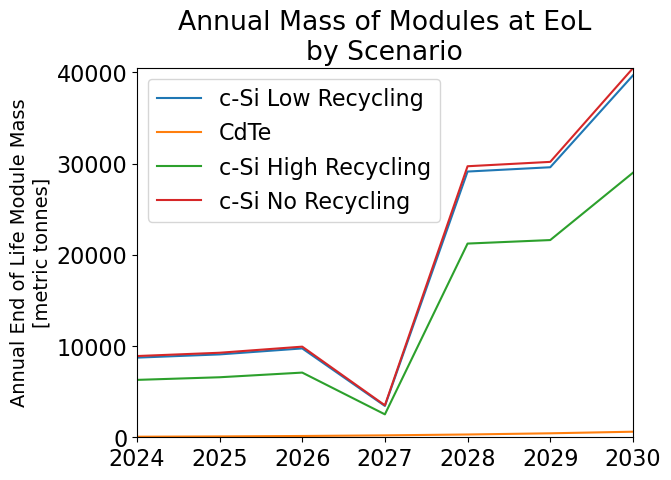

In [37]:
plt.plot(annualEoLModules_tonnes)
plt.legend(['c-Si Low Recycling','CdTe','c-Si High Recycling','c-Si No Recycling'])
plt.ylim(0,40500)
plt.xlim(2024,2030)
plt.ylabel('Annual End of Life Module Mass\n[metric tonnes]', fontsize=14)
plt.title('Annual Mass of Modules at EoL\nby Scenario')